In [1]:
import torch
from vit_pytorch import ViT
from dqn_agent import *
from train_test_agent import *
from viz import *
from rl_env import *
from vit import *
from tinyimagenet import TinyImageNet
import torchvision.transforms as transforms
import torchvision
# import os

In [2]:
models_save_path        = "./model"
results_save_path_agent = "./result"
dataset_path            = "./dataset"

In [3]:
from pathlib import Path


device_their = torch.device("cpu")
device_our = torch.device("cpu")
device_baseline = torch.device("cpu")


## Define what dataset we're using.
datasets = ["tinyimagenet", "cifar10"]
dataset_idx = 1 #Toggle for choosing dataset
dataset_name = datasets[dataset_idx]
use_subset = False
subset_classes = 20
load_indices = True

if dataset_idx == 0:
    img_size = 64
elif dataset_idx == 1:
    img_size = 32

img_size = 32
patch_size = 4
att_dim = 128
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
batch_size = 128


# Create dataset loaders and transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(img_size, padding=8),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])

transform_validation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])

# Prepare and load TinyImageNet dataset
if (dataset_idx == 0):
    trainset_pure = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False)
    trainset =      TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False, transform=transform_train)
    validationset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="val",imagenet_idx=False, transform=transform_validation)

# Prepare/download CIFAR10 dataset
if (dataset_idx == 1):
    trainset_pure = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    trainset =      torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_train)
    validationset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_validation)

# Create empty training and validation loaders
train_loader = None
validation_loader = None
test_loader = None

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Define Model and Training Parameters

In [4]:
buffer_batch_size = 8
buffer_size = 64

gamma = 0.95

eps_start = 1
eps_end = 0.01
eps = eps_start
eps_decay = 20000

lr = 0.01

tau = 0.1
update_every = 2

get_reward_every = 10

ourPretrained = False  # Pretrained with CIFAR10 weights, that is.
pretrained = False
verbose = False     # Whether to print out training progress or not

max_reward = 10
alpha = 0.2 # Where alpha defines weight of loss reward, and 1-alpha defines weight of patch (time) reward
# loss_weight = max_reward*(alpha)  # TODO THIS ONE TOO
# time_weight = max_reward*(1-alpha) # TODO PLAY WITH THESE VALUES A LOT
loss_weight = alpha
time_weight = 1-alpha

# Input image to DQN agent's  Q-network
# for CIFAR, lowres=16, fullres=32
# For TinyImageNet, halfres = 32, fullres = 64
dqn_img_w = img_size // 2
dqn_input_channels = 3
dqn_input_size = dqn_img_w*dqn_img_w*dqn_input_channels # input to DQN (mlp type)a

In [5]:
# This is the number of patches along the width/height of the square image.
# TODO refactor...img_size is defined WAY up in the notebook, right before dataset loader initialization
patch_width = 4
# patch_size = int(img_size/patch_width)
patch_size = patch_width # This is what you get when you work with someone else's code and don't want to rewrite everything.


total_patches = int((img_size/patch_width)**2)
print(total_patches)
n_patch_selected = int(total_patches*(40/64)) # From the paper


att_dim = 128

epochs = 20
save_every = 10
learning_rate = 0.001


# Definte the three transformer models.
SimpleAgentViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

OurViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

BaselineSimpleViT = SimpleViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

# Sposta il modello sulla GPU (se disponibile)
SimpleAgentViTnet.to(device_their)
OurViTnet.to(device_our)
BaselineSimpleViT.to(device_baseline)
    
# definiamo l'ottimizzatore
SimpleOptimizer =   optim.Adam(SimpleAgentViTnet.parameters(), lr=learning_rate)
OurOptimizer =      optim.Adam(OurViTnet.parameters(), lr=learning_rate)
BaselineOptimizer = optim.Adam(BaselineSimpleViT.parameters(), lr=learning_rate)

64


## Create TrainingTesting Agents and Load in Model Weights

In [6]:
testingAgents = dict()

##  Create all of the trainingtestingagents, and load in the model parameters where appropriate
#env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected)
theirEnv = ViTEnv(SimpleAgentViTnet, total_patches, SimpleOptimizer, loss_weight, time_weight, device_their, n_patch_selected, verbose=verbose, total_epochs=epochs)
ourEnv = OurViTEnv(OurViTnet, total_patches, OurOptimizer, loss_weight, time_weight, device_our, n_patch_selected, verbose=verbose, total_epochs=epochs)

ourModel = OurTrainingTestingAgent(epochs = epochs,
                             model = OurViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = ourEnv,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device_our,
                             dqn_input_size=dqn_input_size,
                             save_every=save_every,
                             verbose=verbose,
                             pretrained=ourPretrained)

theirModel = TrainingTestingAgent(epochs = epochs,
                             model = SimpleAgentViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = theirEnv,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             save_every=save_every,
                             verbose=verbose,
                             device = device_their)

baselineModel = SimpleViTTrainingTestingAgent(epochs = epochs,
                             batch_size = batch_size, 
                             model = BaselineSimpleViT,
                             train_loader = train_loader, 
                             validation_loader = validation_loader, 
                             device = device_baseline,
                             optimizer=BaselineOptimizer, 
                            #  criterion=criterion,
                             save_every=save_every, 
                             verbose=verbose)

ConvNet created! Value of pretrained: False
ConvNet created! Value of pretrained: False


In [7]:
# Build the paths to the model files
agent_names = ["ourAgent_qnetwork", "theirAgent_qnetwork"]
vitnet_names = ["ourViTNet", "theirViTNet", "simpleViTNet"]
epochs = [10,20]
datasets = ["cifar10", "tinyimagenet"]
# if selecting just one dataset, modify this
dataset = datasets[0] 
epoch = epochs[-1]
path_base = 'model/'

# Modify this to match the timestamp of the model file you want to load
timestamp = "02_03_13" 

agent_paths = dict()
vitnet_paths = dict()


for epoch in epochs:
    for i, vitnet in enumerate(vitnet_names):
        vitnet_path = path_base + vitnet + "_epoch_" + str(epoch) + "_" + dataset + "_" + timestamp + ".pth"
        if vitnet not in vitnet_paths:
            vitnet_paths[vitnet] = {}
        vitnet_paths[vitnet][epoch] = vitnet_path

    for i, agent in enumerate(agent_names):
        agent_path = path_base + agent + "_epoch_" + str(epoch) + "_" + dataset + "_" + timestamp + ".pth"
        if agent not in agent_paths:
            agent_paths[agent] = {}
        agent_paths[agent][epoch] = agent_path
        
# for vitnet in vitnet_names:
#     vitnet_path = path_base + vitnet + "_epoch_" + str(epoch) + "_" + dataset + "_" + timestamp + ".pth"
#     vitnet_paths.append(vitnet_path)

# for agent in agent_names:
#     agent_path = path_base + agent + "_epoch_" + str(epoch) + "_" + dataset + "_" + timestamp + ".pth"
#     agent_paths.append(agent_path)



C:\Users\Patrick\AppData\Local\Temp\ipykernel_11132\2978164470.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ourModel.ViTnet.load_state_dict(torch.load(vitnet_paths[v

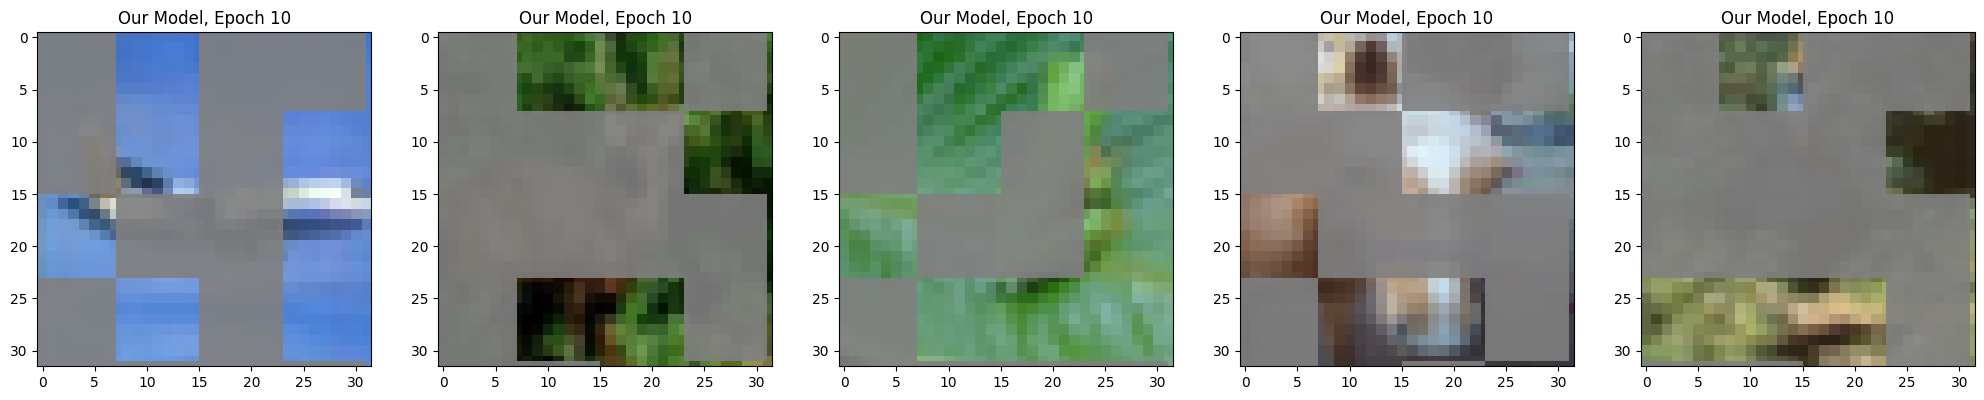

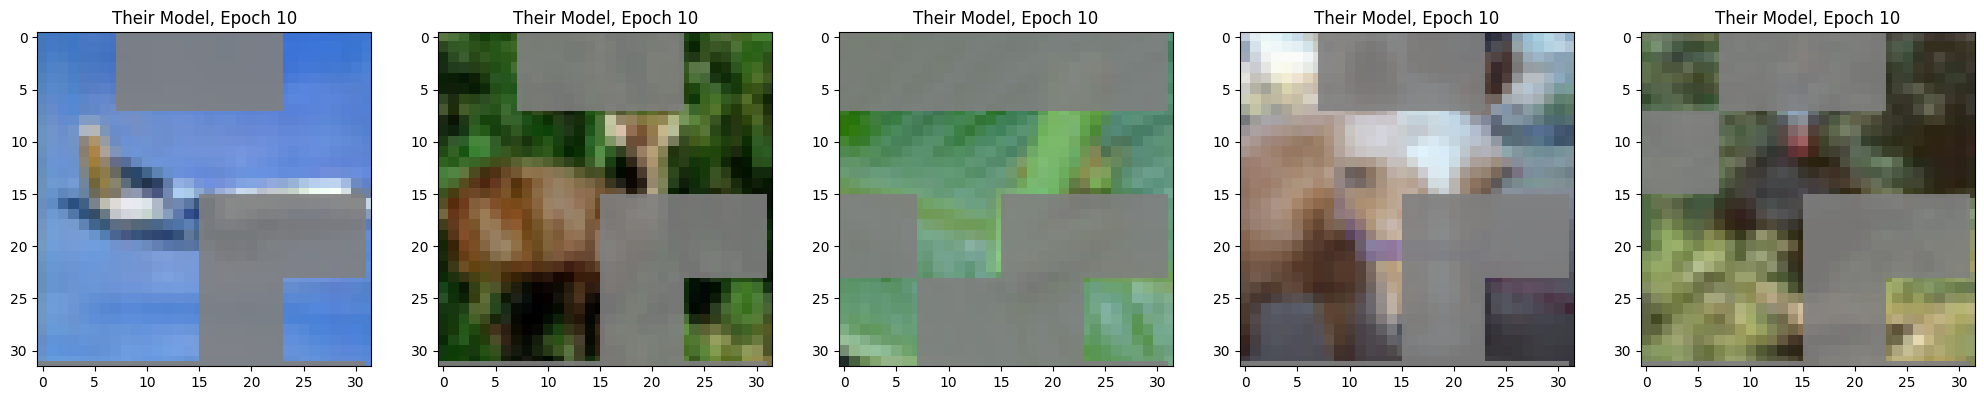

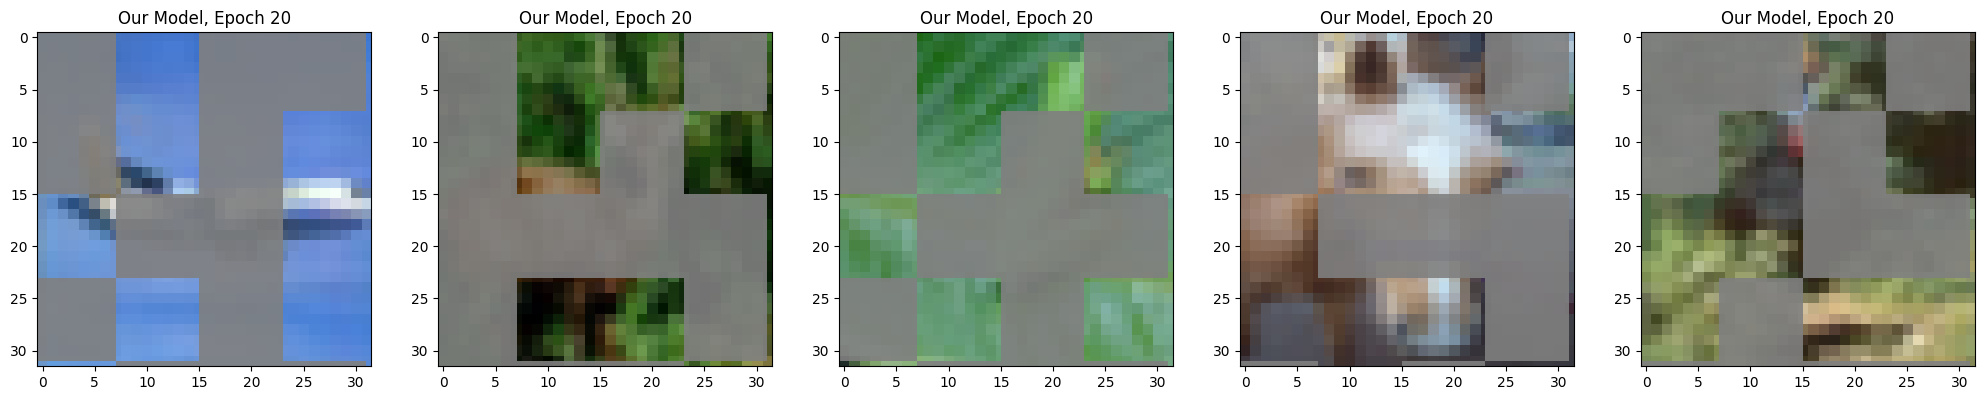

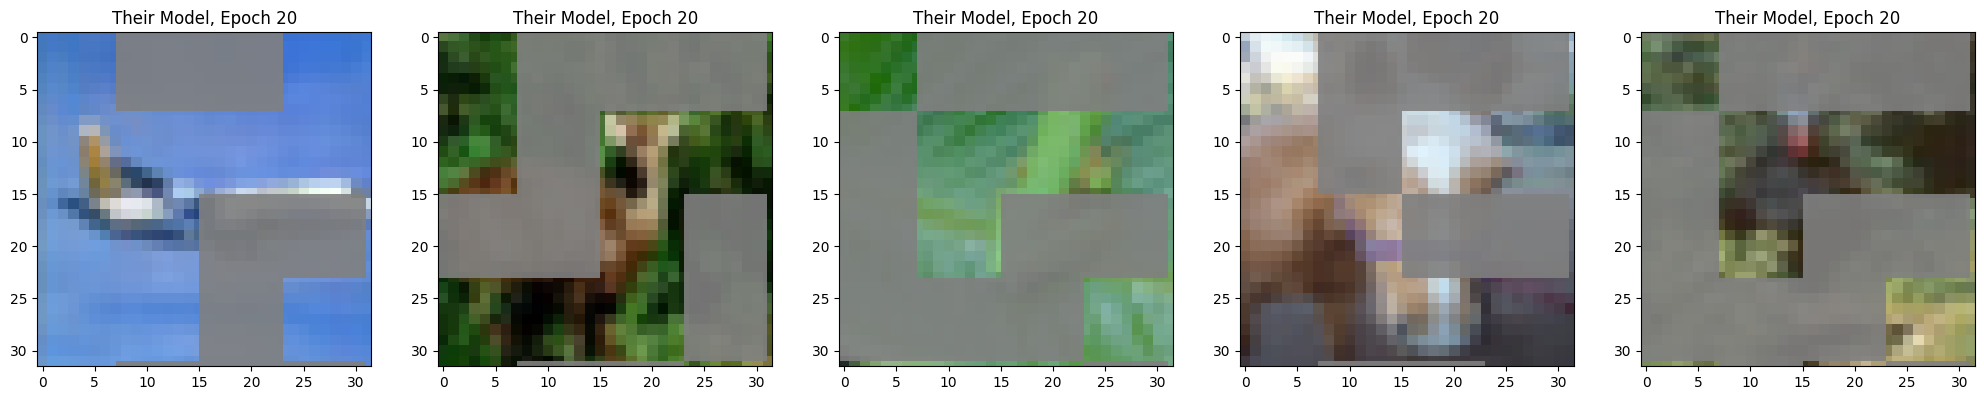

In [13]:
## Visualize the patch selection and attention scores for the untrained models.
## Use functions defined in viz.py
# Select a random set of 5 images from the dataset
num_images = 5
random_indices = np.random.choice(len(trainset_pure), num_images, replace=False)
random_images = [trainset_pure[i][0] for i in random_indices]



half_norm_transform = transforms.Compose(
    [transforms.Resize((img_size // 2, img_size // 2)), 
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std)]
    )


# Load the weights for the ViT models and agents for each epoch
for epoch in epochs:
    ourModel.ViTnet.load_state_dict(torch.load(vitnet_paths[vitnet_names[0]][epoch], map_location=device_our))
    theirModel.ViTnet.load_state_dict(torch.load(vitnet_paths[vitnet_names[1]][epoch], map_location=device_their))
    baselineModel.ViTnet.load_state_dict(torch.load(vitnet_paths[vitnet_names[2]][epoch], map_location=device_baseline))

    ourModel.agent.q_network.load_state_dict(torch.load(agent_paths[agent_names[0]][epoch], map_location=device_our))
    theirModel.agent.q_network.load_state_dict(torch.load(agent_paths[agent_names[1]][epoch], map_location=device_their))

    # Visualize the patch selection and attention scores for the untrained models
    # Visualize patch selection for each model.
    attention_scores_all_images = []
    input_imgs = []
    imgs = []

    for img in random_images:
        # Preprocess the image for the model, depending on the dataset and architecture type.
        if dataset_idx == 0:
            input_img = half_norm_transform(img)
        elif dataset_idx == 1:
            input_img = transforms.ToTensor()(img)
            img = transforms.ToTensor()(img)

        attention_scores_all_images.append(theirModel.ViTnet.get_att(img.unsqueeze(0).to(device_their)))
        imgs.append(img)
        input_imgs.append(input_img)

    visualize_selected_patches_multiple_images(imgs, input_imgs, ourModel.agent, device_our, titles=["Our Model, Epoch " + str(epoch) for i in range(num_images)])
    visualize_selected_patches_multiple_images(imgs, attention_scores_all_images, theirModel.agent, device_their, titles=["Their Model, Epoch " + str(epoch) for i in range(num_images)])
    # visualize_selected_patches_multiple_images(random_images, baselineModel.agent, device_baseline, title=["Baseline Model, Epoch " + str(epoch) for i in range(len(num_images))])



# # Load the weights for the ViT models
# ourModel.ViTnet.load_state_dict(torch.load(vitnet_paths[0], map_location=device_our))
# theirModel.ViTnet.load_state_dict(torch.load(vitnet_paths[1], map_location=device_their))
# baselineModel.ViTnet.load_state_dict(torch.load(vitnet_paths[2], map_location=device_baseline))

# # Load the weights for the agents
# ourModel.agent.q_network.load_state_dict(torch.load(agent_paths[0], map_location=device_our))
# theirModel.agent.q_network.load_state_dict(torch.load(agent_paths[1], map_location=device_their))


